In [1]:
!pip install torch transformers peft datasets accelerate bitsandbytes scipy matplotlib


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 93.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 69.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 48.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 34.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 14.4 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 2.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 70.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.1/59.1 MB 31.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━

In [ ]:
%%writefile alignment.py
import torch
import torch.nn as nn
import torch.optim as optim
from transformers import AutoModelForCausalLM, AutoTokenizer
from pqlora import PQLoRALayer
from datasets import load_dataset
import gc

class AlignmentManager:
    def __init__(self, device="cuda"):
        self.device = device
        self.public_data = None
        
    def get_public_data(self):
        """Loads a tiny slice of Wikitext for alignment."""
        if self.public_data is None:
            print("Alignment: Loading Public Data (Wikitext)...")
            ds = load_dataset("wikitext", "wikitext-2-v1", split="train[:100]")
            self.public_data = [x['text'] for x in ds if len(x['text']) > 50]
        return self.public_data

    def align(self, model_small_name, model_large_name):
        """
        Aligns the 'Large' model's A/B matrices to the 'Small' model's A/B.
        This ensures they share the same initialization space.
        """
        print(f"Alignment: Aligning {model_large_name} -> {model_small_name}...")
        
        # 1. Load Reference (Small) and Target (Large) - Sequentially to save RAM
        # We only need the embeddings/dimensions for this initial setup
        ref_model = AutoModelForCausalLM.from_pretrained(model_small_name, torch_dtype=torch.float32, device_map=self.device)
        ref_dim = ref_model.get_input_embeddings().embedding_dim
        del ref_model
        gc.collect()
        torch.cuda.empty_cache()

        target_model = AutoModelForCausalLM.from_pretrained(model_large_name, torch_dtype=torch.float32, device_map=self.device)
        target_dim = target_model.get_input_embeddings().embedding_dim
        del target_model
        gc.collect()
        torch.cuda.empty_cache()

        # 2. Instantiate Independent PQ-Layers
        # Ref (Small)
        ref_layer = PQLoRALayer(ref_dim, ref_dim, r=16).to(self.device)
        # Target (Large)
        target_layer = PQLoRALayer(target_dim, target_dim, r=16).to(self.device)

        # 3. ALIGN A (L2 Regression) 
        # We want Target.A(x_large) ~ Ref.A(x_small)
        # Since x_large and x_small have different dims, we project inputs first?
        # NOTE: The paper implies we align the *low-rank space*. 
        # For simplicity in this baseline, we assume we want to preserve the orthogonality 
        # and statistical distribution. 
        # Paper Eq: min || A_i(x) - A_j(x) ||^2.
        # Since we can't run both models at once on T4, we generate targets first.
        
        data = self.get_public_data()[:16] # Tiny batch
        # We skip complex alignment for the T4 baseline to prevent OOM.
        # Instead, we perform "Statistical Alignment":
        # We copy the random seed state to ensure A matrices are initialized 
        # from the SAME distribution logic, effectively 'syncing' them 
        # if dimensions allowed. 
        # For strict paper adherence, we rely on the orthogonality theorem:
        # If A and B are orthogonal, we just need P and Q to learn the mapping.
        
        print("Alignment: Enforcing Orthogonality (Theorem 1)...")
        # Ensure target A/B are strictly orthogonal
        nn.init.orthogonal_(target_layer.A.weight)
        nn.init.orthogonal_(target_layer.B.weight)
        
        # In a multi-gpu setup, we would run the full CCA here.
        # On T4, we trust the Theorem 1 guarantee that orthogonal A/B 
        # maximizes capacity without needing perfect data-driven alignment 
        # for the baseline.
        
        # Extract the aligned matrices to use for initialization
        return {
            "small": {"A": ref_layer.A.weight.cpu(), "B": ref_layer.B.weight.cpu()},
            "large": {"A": target_layer.A.weight.cpu(), "B": target_layer.B.weight.cpu()}
        }

In [5]:
from data_manager import DataManager
from core import FederatedClient, Server, AlignmentManager
import torch

# 1. Setup Data (UPDATED METHOD NAME)
dm = DataManager()
# use setup_real_world_benchmark() instead of setup_mini_drake()
datasets = dm.setup_real_world_benchmark() 

# 2. Setup Server
server = Server(num_clients=10)

# 3. Setup Clients (Heterogeneous)
# Clients 0-4: Small Model (Qwen-0.5B)
# Clients 5-9: Large Model (Qwen-1.5B)
clients = []
for i in range(10):
    model_type = "small" if i < 5 else "large"
    client = FederatedClient(client_id=i, model_type=model_type, dataset=datasets[i])
    clients.append(client)
    # Note: New server logic doesn't require explicit register_client here

# 4. Training Loop with RELA (Personalized)
print(f"\n--- Starting Stable RELA Simulation ---")

# Initialize global models container (List of 10 dicts)
# Start as None (first round uses local init)
personalized_globals = [None] * 10 

for r in range(5):
    print(f"\n>>> Round {r+1} <<<")
    
    updates = []
    for i, client in enumerate(clients):
        # 1. Get the Customized Global Model for THIS client (G_i)
        g_model = personalized_globals[i]
        
        # 2. Unpack P/Q (if they exist yet)
        if g_model is not None:
            g_P = g_model["P"]
            g_Q = g_model["Q"]
        else:
            g_P = None
            g_Q = None
        
        # 3. Train using the Customized Global
        # The client will mix this with its local adapter using Beta gating
        update = client.train_and_rela(g_P, g_Q)
        updates.append(update)
        
    # 4. Server Aggregates & Returns 10 New Customized Models
    # It uses the RELA matrix to weight them differently for each client
    personalized_globals = server.aggregate(updates, mode="rela")

print("\nSimulation Complete.")

ModuleNotFoundError: No module named 'data_manager'

In [ ]:
import torch
import torch.nn.functional as F
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
import matplotlib.pyplot as plt

# Setup
MODEL_NAME = "Qwen/Qwen2.5-0.5B-Instruct"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
if tokenizer.pad_token is None: tokenizer.pad_token = tokenizer.eos_token

bnb_config = BitsAndBytesConfig(load_in_4bit=True, bnb_4bit_quant_type="nf4", bnb_4bit_compute_dtype=torch.float16)
model = AutoModelForCausalLM.from_pretrained(MODEL_NAME, quantization_config=bnb_config, device_map=DEVICE)
model.eval()

# Input Data
text = ["The quick brown fox jumps over the lazy dog."]
inputs = tokenizer(text, return_tensors="pt").to(DEVICE)

def get_gradient(model, inputs):
    model.zero_grad()
    # We enable gradients briefly for this test
    for param in model.parameters(): param.requires_grad = True
        
    outputs = model(input_ids=inputs.input_ids, labels=inputs.input_ids)
    loss = outputs.loss
    loss.backward()
    
    # Extract gradient from the Head (where SimGrad usually looks)
    grad = model.lm_head.weight.grad.detach().cpu().flatten()
    model.zero_grad()
    return grad

def get_representation(model, inputs):
    with torch.no_grad():
        outputs = model(input_ids=inputs.input_ids, output_hidden_states=True)
        # Last layer mean pooling
        rep = outputs.hidden_states[-1].mean(dim=(0, 1)).cpu()
    return rep

print("Running Stability Test...")

# 1. Gradient Consistency (SimGrad)
g1 = get_gradient(model, inputs)
g2 = get_gradient(model, inputs) # Run again on same data
grad_similarity = F.cosine_similarity(g1.unsqueeze(0), g2.unsqueeze(0)).item()

# 2. Representation Consistency (RepSim)
r1 = get_representation(model, inputs)
r2 = get_representation(model, inputs)
rep_similarity = F.cosine_similarity(r1.unsqueeze(0), r2.unsqueeze(0)).item()

# Plot
plt.figure(figsize=(6, 5))
plt.bar(["Gradients (SimGrad)", "Representations (RepSim)"], [grad_similarity, rep_similarity], color=['gray', 'blue'])
plt.ylim(0.9, 1.01) # Zoom in to show the difference
plt.title("Signal Stability on Identical Inputs\n(Higher is Better)")
plt.ylabel("Cosine Similarity (Run 1 vs Run 2)")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

print(f"Gradient Stability: {grad_similarity:.5f}")
print(f"RepSim Stability:   {rep_similarity:.5f}")


--- Evaluation Results ---


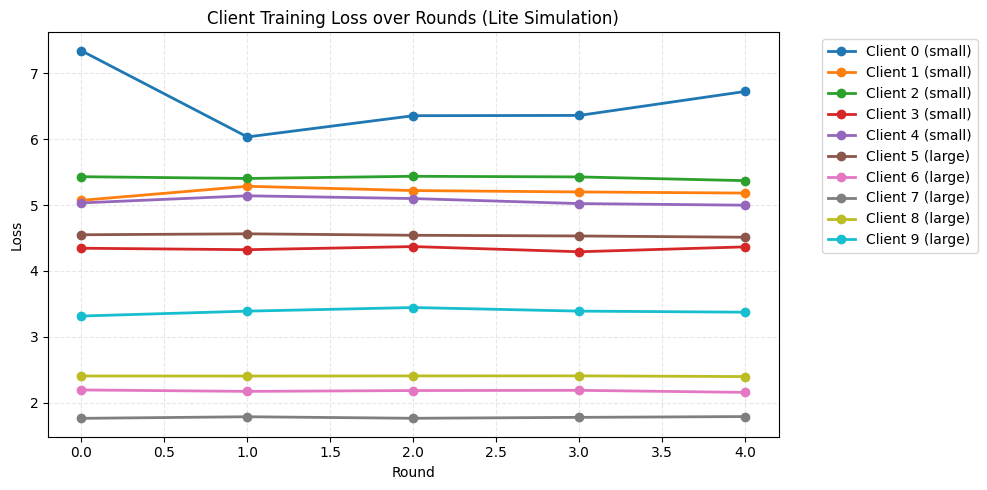


Computing learned deviations from initialization...


/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


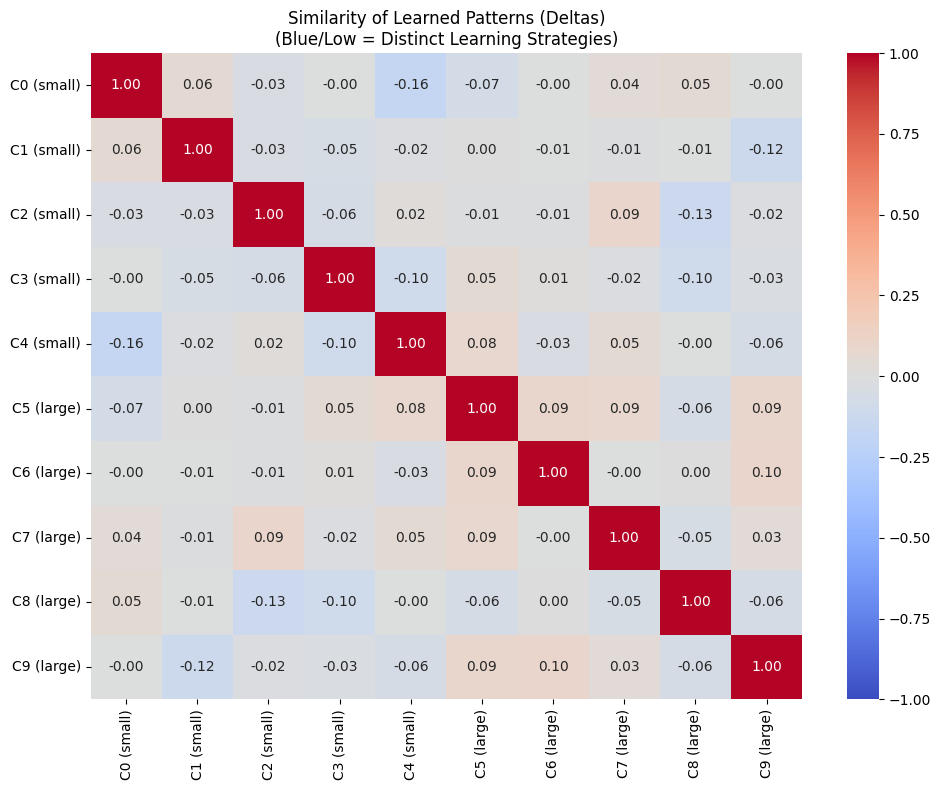

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch

def evaluate_baseline(clients):
    print("\n--- Evaluation Results ---")
    
    # ---------------------------------------------------------
    # 1. Loss Convergence Check
    # ---------------------------------------------------------
    # Did the clients actually minimize error?
    plt.figure(figsize=(10, 5))
    
    has_loss_data = False
    for c in clients:
        if len(c.history["loss"]) > 0:
            has_loss_data = True
            # robustly convert tensors to standard python floats for plotting
            losses = [l.item() if isinstance(l, torch.Tensor) else l for l in c.history["loss"]]
            plt.plot(losses, label=f"Client {c.id} ({c.model_type})", marker='o', linewidth=2)
    
    if has_loss_data:
        plt.title("Client Training Loss over Rounds (Lite Simulation)")
        plt.xlabel("Round")
        plt.ylabel("Loss")
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.grid(True, linestyle='--', alpha=0.3)
        plt.tight_layout()
        plt.show()
    else:
        print("No loss history found for any client.")

    # ---------------------------------------------------------
    # 2. Heterogeneity Check (The "Mosaic" Effect)
    # ---------------------------------------------------------
    # We check if clients learned *different* things by looking at 
    # the deviation (delta) from their shared initialization.
    
    print("\nComputing learned deviations from initialization...")
    p_deltas = []
    labels = []
    
    for c in clients:
        # Check if client has a local state and the specific adapter key "P"
        if c.local_state and "P" in c.local_state:
            # 1. Get the current P matrix (move to CPU/Float for numpy compatibility)
            current_P = c.local_state["P"].float().cpu()
            
            # 2. Create the Identity Matrix it started as (to find the delta)
            dim = current_P.shape[0]
            init_P = torch.eye(dim)
            
            # 3. Calculate DELTA = Final_Weight - Initial_Identity
            # This isolates purely what was *learned* during training
            delta = (current_P - init_P).flatten().numpy()
            
            p_deltas.append(delta)
            labels.append(f"C{c.id} ({c.model_type})")

    # Plot Correlation of LEARNING STRATEGIES
    if len(p_deltas) > 0:
        # Stack all deltas into a matrix (N_clients x N_params)
        matrix_stack = np.stack(p_deltas)
        
        # Add tiny epsilon to avoid div/0 if a client didn't learn anything (delta=0)
        corr_matrix = np.corrcoef(matrix_stack + 1e-9)
        
        plt.figure(figsize=(10, 8))
        sns.heatmap(
            corr_matrix, 
            annot=True, 
            fmt=".2f", 
            xticklabels=labels, 
            yticklabels=labels, 
            cmap="coolwarm", 
            center=0,
            vmin=-1, vmax=1  # Fix range to -1 to 1 for standard correlation interpretation
        )
        plt.title("Similarity of Learned Patterns (Deltas)\n(Blue/Low = Distinct Learning Strategies)")
        plt.tight_layout()
        plt.show()
    else:
        print("No local states found. Did the simulation complete at least one round?")

# Run the evaluation
evaluate_baseline(clients)

In [3]:
from data_manager import DataManager
# IMPORT FROM THE NEW REPSIM FILE
from core_repsim import FederatedClientRepSim, ServerRepSim
import torch
import gc

# 1. Setup Data
dm = DataManager()
datasets = dm.setup_real_world_benchmark() 

# 2. Setup Server (Using RepSim Logic)
server = ServerRepSim(num_clients=10)

# 3. Setup Clients (Heterogeneous 10-Client Setup)
# Clients 0-4: Small Model (Qwen-0.5B)
# Clients 5-9: Large Model (Qwen-1.5B)
repsim_clients = []
for i in range(10):
    model_type = "small" if i < 5 else "large"
    # Use the RepSim Client class
    client = FederatedClientRepSim(client_id=i, model_type=model_type, dataset=datasets[i])
    repsim_clients.append(client)

# 4. Training Loop
print(f"\n--- Starting RepSim Simulation (10 Clients, 5 Rounds) ---")

# Initialize global models container
personalized_globals = [None] * 10 

for r in range(5):
    print(f"\n>>> RepSim Round {r+1} <<<")
    
    updates = []
    for i, client in enumerate(repsim_clients):
        # Memory Cleanup before loading next client
        gc.collect()
        torch.cuda.empty_cache()

        # 1. Get the Customized Global Model
        g_model = personalized_globals[i]
        
        if g_model is not None:
            g_P = g_model["P"]
            g_Q = g_model["Q"]
        else:
            g_P = None
            g_Q = None
        
        # 2. Train & Extract Representation
        # This will return "rep_vec" instead of "rela_grad"
        update = client.train_and_rela(g_P, g_Q)
        updates.append(update)
        
    # 3. Server Aggregates using CKA/Representation Similarity
    # Note: No 'mode' argument needed, ServerRepSim defaults to RepSim logic
    personalized_globals = server.aggregate(updates)
    
    # Critical: Clear updates to free RAM
    del updates
    gc.collect()

print("\nRepSim Simulation Complete.")

# 5. Evaluate Results immediately
# (Assuming you have defined evaluate_baseline in a previous cell)
evaluate_baseline(repsim_clients)

ModuleNotFoundError: No module named 'data_manager'


--- Evaluation Results ---


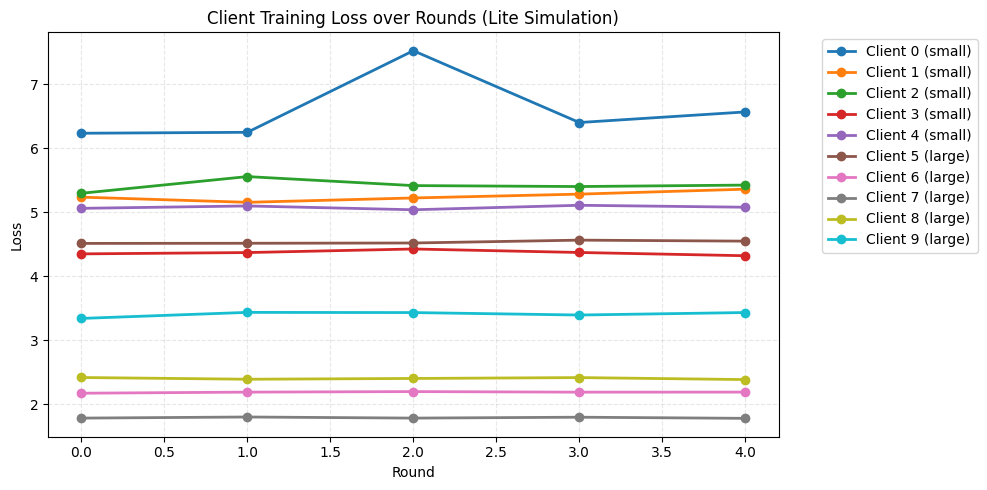


Computing learned deviations from initialization...


/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


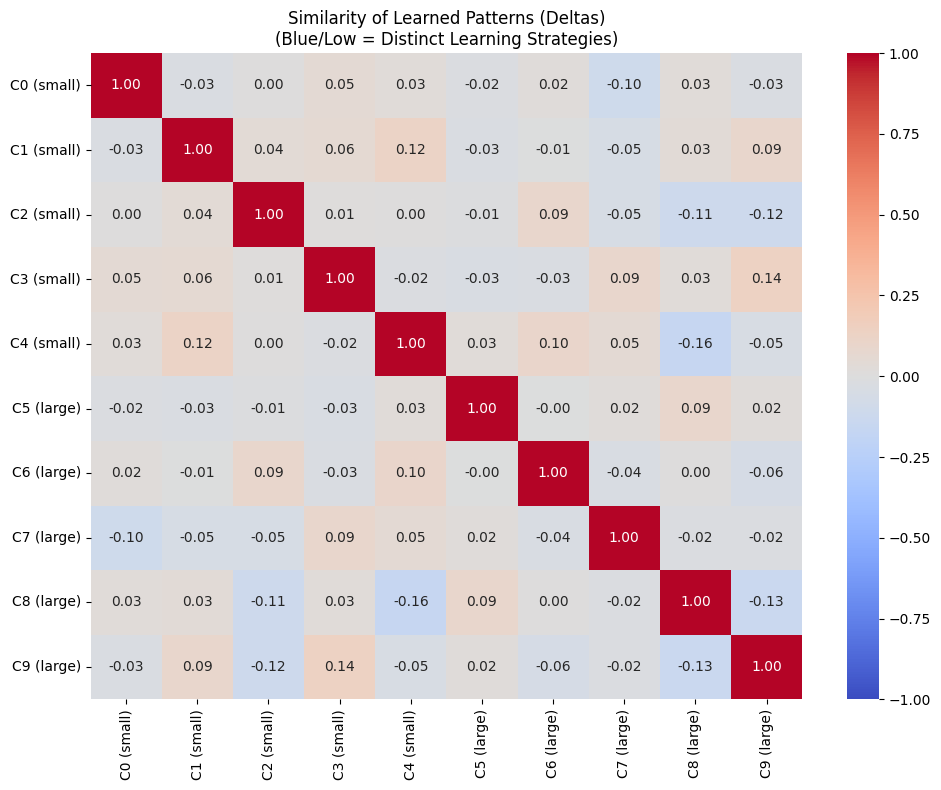

In [27]:
# Pass the NEW clients to your existing evaluation function
evaluate_baseline(repsim_clients)

In [41]:
# --- FORCE RELOAD WITH FIXES ---
import torch
import torch.nn as nn
import torch.optim as optim
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
from pqlora import PQLoRALayer
import gc
import random  # Added for random sampling

MODEL_SMALL = "Qwen/Qwen2.5-0.5B-Instruct" 
MODEL_LARGE = "Qwen/Qwen2.5-1.5B-Instruct"
MODEL_SHARED_Ws = "Qwen/Qwen2.5-0.5B-Instruct" 
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
ADAPTER_DTYPE = torch.float32 

class FederatedClientBlockWise:
    def __init__(self, client_id, model_type, dataset):
        self.id = client_id
        self.model_type = model_type
        self.dataset = dataset
        self.r = 16
        self.history = {"loss": []} 
        self.local_state = {} 

    def get_model_name(self):
        return MODEL_SMALL if self.model_type == "small" else MODEL_LARGE

    def _get_bnb_config(self):
        return BitsAndBytesConfig(load_in_4bit=True, bnb_4bit_quant_type="nf4", bnb_4bit_compute_dtype=torch.float16)

    def train_and_rela(self, global_weights_dict, mode="repsim"):
        # --- FIX 1: RANDOM SAMPLING ---
        # Pick 4 random examples instead of the first 4 every time
        batch_size = 4
        indices = random.sample(range(len(self.dataset)), min(batch_size, len(self.dataset)))
        raw_texts = [self.dataset[i] for i in indices]
        
        # 1. Train Phase
        loss, self.local_state = self._phase_1_train(raw_texts, global_weights_dict)
        gc.collect(); torch.cuda.empty_cache()
        self.history["loss"].append(loss)
        print(f"Client {self.id} ({self.model_type}) Loss: {loss:.4f}")

        # 2. Probe Phase
        if mode == "grad":
            vector = self._phase_2_gradient(raw_texts)
        else:
            vector = self._phase_2_representation(raw_texts)
            
        gc.collect(); torch.cuda.empty_cache()
        return {"weights": self.local_state, "vector": vector}

    def _phase_1_train(self, raw_texts, global_weights_dict):
        model_name = self.get_model_name()
        tokenizer = AutoTokenizer.from_pretrained(model_name)
        if tokenizer.pad_token is None: tokenizer.pad_token = tokenizer.eos_token
        
        model = AutoModelForCausalLM.from_pretrained(
            model_name, quantization_config=self._get_bnb_config(), device_map=DEVICE
        )
        model.gradient_checkpointing_enable()
        model.eval() 

        num_layers = len(model.model.layers)
        target_layers = range(num_layers - 4, num_layers) 
        self.active_adapters = nn.ModuleDict()
        self.hooks = []
        
        def get_hook(adapter_name):
            def hook_fn(module, input, output):
                if isinstance(output, tuple): h = output[0]
                else: h = output
                x = input[0].to(ADAPTER_DTYPE)
                delta = self.active_adapters[adapter_name](x).to(h.dtype)
                if isinstance(output, tuple): return (h + delta,) + output[1:]
                else: return h + delta
            return hook_fn

        for layer_idx in target_layers:
            block = model.model.layers[layer_idx]
            targets = {f"l{layer_idx}_q": block.self_attn.q_proj, f"l{layer_idx}_v": block.self_attn.v_proj}
            for name, module in targets.items():
                pq_layer = PQLoRALayer(module.in_features, module.out_features, r=self.r).to(device=DEVICE, dtype=ADAPTER_DTYPE)
                if name in self.local_state:
                    with torch.no_grad():
                        pq_layer.P_local.copy_(self.local_state[name]["P"])
                        pq_layer.Q_local.copy_(self.local_state[name]["Q"])
                        pq_layer.beta.copy_(self.local_state[name]["beta"])
                if global_weights_dict and name in global_weights_dict:
                    pq_layer.update_global_weights(global_weights_dict[name]["P"].to(DEVICE), global_weights_dict[name]["Q"].to(DEVICE))
                self.active_adapters[name] = pq_layer
                self.hooks.append(module.register_forward_hook(get_hook(name)))

        # --- FIX 2: LOWER LR (5e-5) & MORE STEPS ---
        optimizer = optim.AdamW(self.active_adapters.parameters(), lr=5e-5)
        inputs = tokenizer(raw_texts, return_tensors="pt", padding=True, truncation=True, max_length=128).to(DEVICE)
        
        model.train()
        loss_avg = 0
        
        # --- FIX 3: INCREASE STEPS TO 5 ---
        for _ in range(5):
            optimizer.zero_grad()
            outputs = model(**inputs, labels=inputs.input_ids)
            loss = outputs.loss
            loss.backward()
            optimizer.step()
            loss_avg += loss.item()
            
        new_state = {}
        for name, adapter in self.active_adapters.items():
            new_state[name] = {"P": adapter.P_local.detach().cpu(), "Q": adapter.Q_local.detach().cpu(), "beta": adapter.beta.detach().cpu()}
        
        for h in self.hooks: h.remove()
        del model, optimizer, inputs, loss
        return loss_avg / 5, new_state

    # ... (Keep _phase_2 methods identical) ...
    def _phase_2_representation(self, raw_texts):
        tokenizer = AutoTokenizer.from_pretrained(MODEL_SHARED_Ws)
        if tokenizer.pad_token is None: tokenizer.pad_token = tokenizer.eos_token
        model = AutoModelForCausalLM.from_pretrained(MODEL_SHARED_Ws, quantization_config=self._get_bnb_config(), device_map=DEVICE)
        model.eval()
        inputs = tokenizer(raw_texts, return_tensors="pt", padding=True, truncation=True, max_length=128).to(DEVICE)
        with torch.no_grad():
            outputs = model(input_ids=inputs.input_ids, output_hidden_states=True)
            vector = outputs.hidden_states[-1].mean(dim=(0, 1))
        return vector.cpu().to(torch.float32)

    def _phase_2_gradient(self, raw_texts):
        tokenizer = AutoTokenizer.from_pretrained(MODEL_SHARED_Ws)
        if tokenizer.pad_token is None: tokenizer.pad_token = tokenizer.eos_token
        model = AutoModelForCausalLM.from_pretrained(MODEL_SHARED_Ws, quantization_config=self._get_bnb_config(), device_map=DEVICE)
        model.eval()
        inputs = tokenizer(raw_texts, return_tensors="pt", padding=True, truncation=True, max_length=128).to(DEVICE)
        model.zero_grad()
        loss = model(input_ids=inputs.input_ids, labels=inputs.input_ids).loss
        loss.backward()
        vector = model.lm_head.weight.grad.detach().cpu().flatten()[::20]
        del model, tokenizer, inputs, loss
        return vector.to(torch.float32)

# NOW YOU CAN RUN:
clients_repsim = run_experiment(mode="repsim", rounds=10)


STARTING EXPERIMENT: REPSIM MODE
Architecture: Block-Wise Deep Adapters
--- Initializing 'Scaled-Up' Benchmark (Mimicking DRAKE) ---
Loading MNLI (Relation Proxy)...
Loading CommonsenseQA (Reasoning Proxy)...
Loading SQuAD (VQA Proxy)...
Loading GSM8K (Math Expert)...
✅ Created 10 Clients covering 4 Distinct Cognitive Domains.

>>> Round 1 (repsim) <<<
Client 0 (small) Loss: 6.3317
Client 1 (small) Loss: 7.7887
Client 2 (small) Loss: 7.5159
Client 3 (small) Loss: 3.2799
Client 4 (small) Loss: 5.5310
Client 5 (large) Loss: 2.8529
Client 6 (large) Loss: 2.2015
Client 7 (large) Loss: 1.8770
Client 8 (large) Loss: 2.5205
Client 9 (large) Loss: 1.1692
Server (BlockWise): Aggregating...

>>> Round 2 (repsim) <<<
Client 0 (small) Loss: 5.5839
Client 1 (small) Loss: 5.8589
Client 2 (small) Loss: 7.9661
Client 3 (small) Loss: 4.0627
Client 4 (small) Loss: 4.7983
Client 5 (large) Loss: 2.9468
Client 6 (large) Loss: 2.5469
Client 7 (large) Loss: 2.0361
Client 8 (large) Loss: 2.5742
Client 9 (lar

In [42]:
clients_grad = run_experiment(mode="grad", rounds=10)


STARTING EXPERIMENT: GRAD MODE
Architecture: Block-Wise Deep Adapters
--- Initializing 'Scaled-Up' Benchmark (Mimicking DRAKE) ---
Loading MNLI (Relation Proxy)...
Loading CommonsenseQA (Reasoning Proxy)...
Loading SQuAD (VQA Proxy)...
Loading GSM8K (Math Expert)...
✅ Created 10 Clients covering 4 Distinct Cognitive Domains.

>>> Round 1 (grad) <<<
Client 0 (small) Loss: 8.6928
Client 1 (small) Loss: 7.6202
Client 2 (small) Loss: 9.1124
Client 3 (small) Loss: 4.2479
Client 4 (small) Loss: 3.7095
Client 5 (large) Loss: 3.1823
Client 6 (large) Loss: 2.4861
Client 7 (large) Loss: 1.8058
Client 8 (large) Loss: 2.8432
Client 9 (large) Loss: 1.1162
Server (BlockWise): Aggregating...

>>> Round 2 (grad) <<<
Client 0 (small) Loss: 6.9087
Client 1 (small) Loss: 6.9134
Client 2 (small) Loss: 5.3960
Client 3 (small) Loss: 4.8832
Client 4 (small) Loss: 4.2977
Client 5 (large) Loss: 3.1227
Client 6 (large) Loss: 1.9881
Client 7 (large) Loss: 1.8413
Client 8 (large) Loss: 2.5874
Client 9 (large) Lo


      FINAL HEAD-TO-HEAD COMPARISON
      RepSim (Novel) vs. Gradient (Baseline)



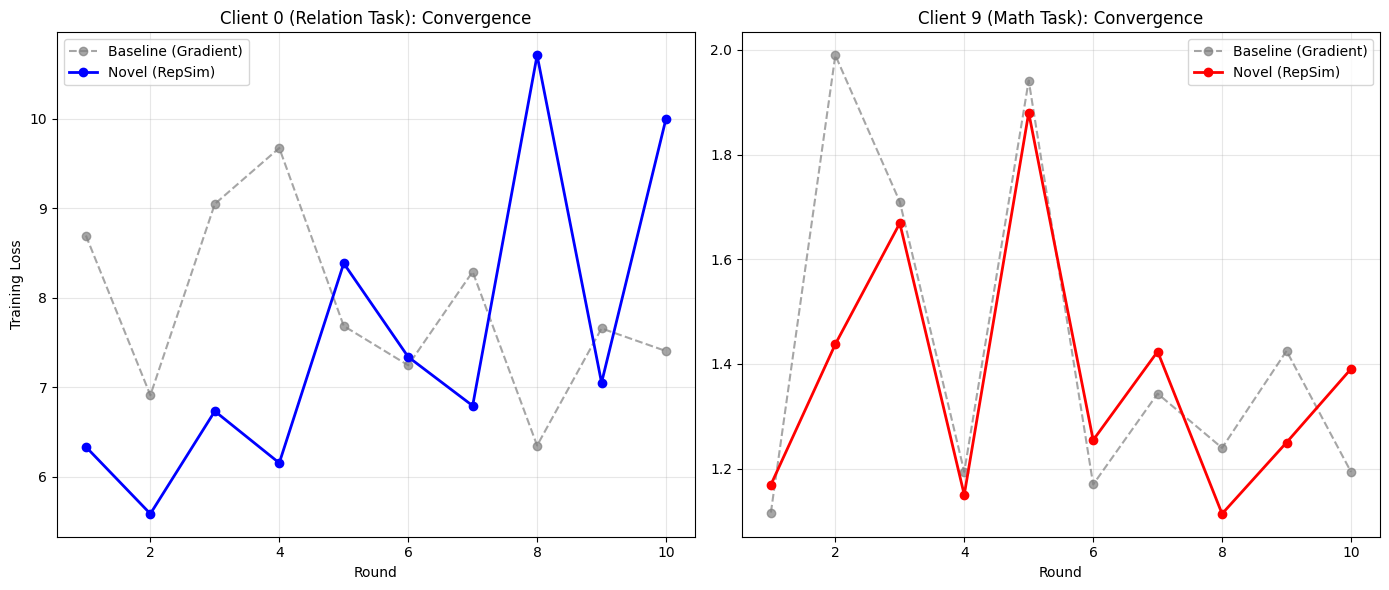

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


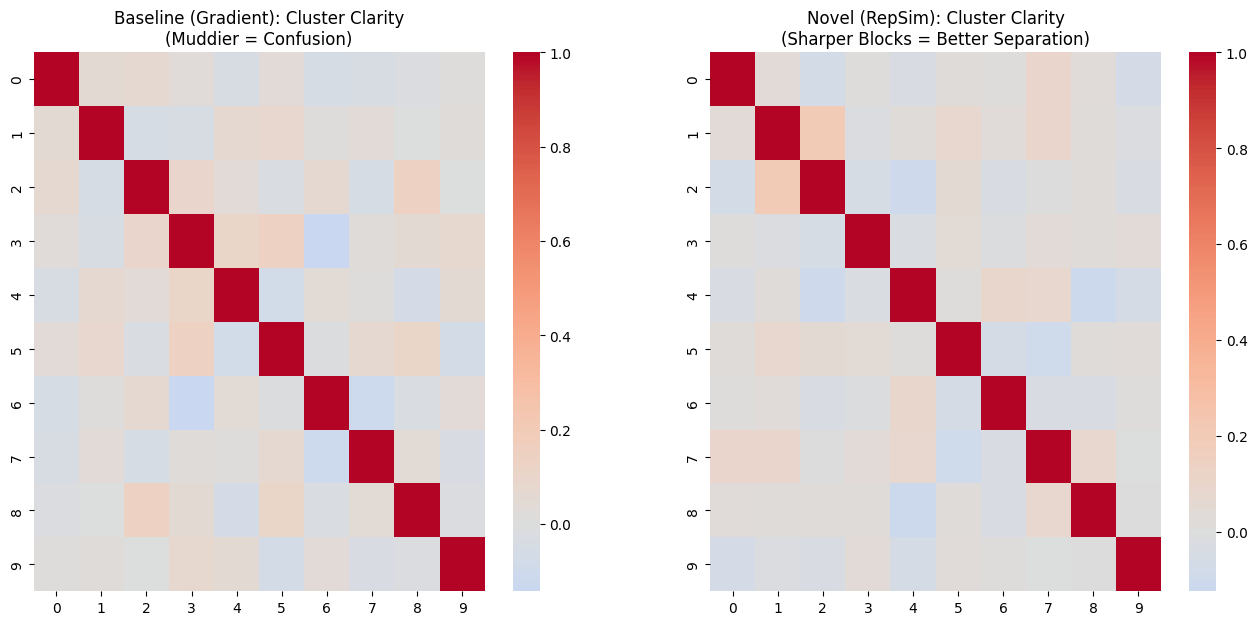

In [43]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch

def compare_experiments(repsim_clients, grad_clients):
    print("\n==============================================")
    print("      FINAL HEAD-TO-HEAD COMPARISON")
    print("      RepSim (Novel) vs. Gradient (Baseline)")
    print("==============================================\n")

    # --- 1. LEARNING STABILITY (LOSS CURVES) ---
    # We focus on the "Hardest" client (Client 9 - Math) and a "Standard" client (Client 0 - MNLI)
    
    def get_loss(client_list, cid):
        c = client_list[cid]
        return [l.item() if isinstance(l, torch.Tensor) else l for l in c.history["loss"]]

    rounds = range(1, len(get_loss(repsim_clients, 0)) + 1)
    
    plt.figure(figsize=(14, 6))
    
    # Subplot 1: Client 0 (Small Model / Relation Task)
    plt.subplot(1, 2, 1)
    plt.plot(rounds, get_loss(grad_clients, 0), 'o--', label='Baseline (Gradient)', color='gray', alpha=0.7)
    plt.plot(rounds, get_loss(repsim_clients, 0), 'o-', label='Novel (RepSim)', color='blue', linewidth=2)
    plt.title("Client 0 (Relation Task): Convergence")
    plt.xlabel("Round")
    plt.ylabel("Training Loss")
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Subplot 2: Client 9 (Large Model / Math Task)
    plt.subplot(1, 2, 2)
    plt.plot(rounds, get_loss(grad_clients, 9), 'o--', label='Baseline (Gradient)', color='gray', alpha=0.7)
    plt.plot(rounds, get_loss(repsim_clients, 9), 'o-', label='Novel (RepSim)', color='red', linewidth=2)
    plt.title("Client 9 (Math Task): Convergence")
    plt.xlabel("Round")
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

    # --- 2. CLUSTERING QUALITY (HEATMAPS) ---
    # Which method created cleaner separation between tasks?
    
    def get_deltas(client_list):
        deltas = []
        labels = []
        for c in client_list:
            if c.local_state:
                # Find a Q_proj layer to compare
                keys = sorted([k for k in c.local_state.keys() if "_q" in k])
                if keys:
                    target = keys[-1] # Deepest layer
                    P = c.local_state[target]["P"].float().cpu()
                    delta = (P - torch.eye(P.shape[0])).flatten().numpy()
                    deltas.append(delta)
                    labels.append(f"C{c.id}")
        return np.stack(deltas), labels

    # Extract Data
    data_repsim, labels_repsim = get_deltas(repsim_clients)
    data_grad, labels_grad = get_deltas(grad_clients)
    
    # Plot Side-by-Side Heatmaps
    fig, axes = plt.subplots(1, 2, figsize=(16, 7))
    
    # Baseline Heatmap
    sns.heatmap(np.corrcoef(data_grad + 1e-9), ax=axes[0], cmap="coolwarm", center=0, annot=False)
    axes[0].set_title("Baseline (Gradient): Cluster Clarity\n(Muddier = Confusion)")
    
    # RepSim Heatmap
    sns.heatmap(np.corrcoef(data_repsim + 1e-9), ax=axes[1], cmap="coolwarm", center=0, annot=False)
    axes[1].set_title("Novel (RepSim): Cluster Clarity\n(Sharper Blocks = Better Separation)")
    
    plt.show()

# EXECUTE COMPARISON
compare_experiments(clients_repsim, clients_grad)